# Library import

In [1]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

In [2]:
userPATH ='revision_dataset/'
tweetPATH = 'revision_dataset/'

In [3]:
userlvltrain = pd.read_csv(userPATH+'/userlvltrain.csv')
userlvltest = pd.read_csv(userPATH+'/userlvltest.csv')
userlvlval = pd.read_csv(userPATH+'/userlvlval.csv')

In [4]:
train_df = pd.read_csv(tweetPATH+'train_df.csv', keep_default_na=False)
test_df = pd.read_csv(tweetPATH+'test_df.csv', keep_default_na=False)
val_df = pd.read_csv(tweetPATH+'val_df.csv', keep_default_na=False)

In [5]:
## prepare data for BERT training and save in newdata/
if not os.path.exists('newdataVote/'): 
    os.mkdir('newdataVote/')
    train_df.to_csv('newdataVote/train.csv', index=False)
    test_df.to_csv('newdataVote/test.csv', index=False)
    val_df.to_csv('newdataVote/dev.csv', index=False)

possible_labels = train_df.userLocation.unique()
possible_labels.sort()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)
inv_label_dict = {v: k for k, v in label_dict.items()}
print(inv_label_dict)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8}
{0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Setting Cuda

In [6]:
!nvidia-smi

Sun Mar 13 15:55:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   34C    P0    56W / 300W |  19642MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   44C    P0   157W / 300W |  16998MiB / 32480MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [7]:
torch.cuda.set_device(7)
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
device_idx = "cuda:7"
torch.cuda.current_device()

7

In [8]:
import random 
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

def location_prediction_metrics(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics


class LocationPredictionDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = label_dict
    INDEX2LABEL = inv_label_dict
    NUM_LABELS = 9
    
    def load_dataset(self, path): 
        df = pd.read_csv(path, sep=',')
        # df.columns = ['screenName','tweets','userLocation', 'mentionedLocation','label', 'final_feat']
        df['userLocation'] = df['userLocation'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
    
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        tweets, labels = data['text'], data['userLocation']
        subwords = self.tokenizer.encode(tweets, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), data['text']
    
    def __len__(self):
        return len(self.data)    
        
class LocationPredictionDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(LocationPredictionDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        class_batch = np.zeros((batch_size, 1), dtype=np.int64)
        
        seq_list = []
        for i, (subwords, tagging, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            class_batch[i,0] = tagging
            
            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, class_batch, seq_list

# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == device_idx:
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label

# Save and Load Functions

# pada fungsi ini dilakukan penyimpanan model, optimizer, dan validation loss
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)

# untuk meload loss yang telah disimpan
def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# pada fungsi ini accuracy dan loss disimpan 
def save_metrics(save_path, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs):

    if save_path == None:
        return
    
    state_dict = {'train_acc_list': train_acc_list,
                  'train_loss_list': train_loss_list,
                  'valid_acc_list': valid_acc_list,
                  'valid_loss_list': valid_loss_list,
                  'epochs_list': epochs}
    
    torch.save(state_dict, save_path)
    # print(f'Model saved to ==> {save_path}')

# fungsi untuk melakukan load accuracy dan loss 
def load_metrics(load_path): 

    if load_path==None:
        return
    state_dict = torch.load(load_path)    
    
    return state_dict['train_acc_list'],state_dict['train_loss_list'], state_dict['valid_acc_list'], state_dict['valid_loss_list'], state_dict['epochs_list']

## Prepare Dataset

In [9]:
set_seed(42)

#Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
config.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', 
                                                      config=config)

train_dataset = LocationPredictionDataset("newdataVote/train.csv", tokenizer, lowercase=True)
valid_dataset = LocationPredictionDataset("newdataVote/dev.csv", tokenizer, lowercase=True)
test_dataset = LocationPredictionDataset("newdataVote/test.csv", tokenizer, lowercase=True)


learning_rate = 2e-5
batch_size = 16
epochs = 7

train_loader = LocationPredictionDataLoader(dataset=train_dataset, max_seq_len=280, batch_size=batch_size, num_workers=16, shuffle=True)  
valid_loader = LocationPredictionDataLoader(dataset=valid_dataset, max_seq_len=280, batch_size=batch_size, num_workers=16, shuffle=False)  
test_loader = LocationPredictionDataLoader(dataset=test_dataset, max_seq_len=280, batch_size=batch_size, num_workers=16, shuffle=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
w2i, i2w = LocationPredictionDataset.LABEL2INDEX, LocationPredictionDataset.INDEX2LABEL
print(w2i, '\n', i2w)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8} 
 {0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Fine Tuning and Evaluation

In [11]:
torch.cuda.empty_cache()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
model = model.to(device)

### training

In [12]:
file_path = 'saved_model_vote/'
if not os.path.exists(file_path): 
    os.mkdir(file_path)

model_name = 'indoNLU_model'
metrics_name = 'indoNLU_metrics'

model_path = file_path+model_name+'_'+str(batch_size)+'_'+str(epochs)+'_'+str(learning_rate)+'.pt'
metrics_path = file_path+metrics_name+'_'+str(batch_size)+'_'+str(epochs)+'_'+str(learning_rate)+'.pt'

In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# list untuk menyimpan data metrics setiap training, untuk memudahkan 
# menampilkan dalam grafik
train_acc_list = [] 
train_loss_list = []
valid_acc_list = [] 
valid_loss_list = []
epochs_list = []

best_valid_loss = float("Inf")
file_path = 'saved_model'

# Train
n_epochs = epochs
for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))

    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    train_loss_list.append(total_train_loss/(i+1))
    train_acc_list.append(metrics['ACC'])
    epochs_list.append(epoch)


    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))

    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = location_prediction_metrics(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    valid_loss_list.append(total_loss/(i+1))
    valid_acc_list.append(metrics['ACC'])

    # checkpoint, untuk menyimpan validation loss dan metrics yang paling baik untuk seluruh epochs 
    if best_valid_loss > total_loss/(i+1):
      best_valid_loss = total_loss/(i+1)
      save_checkpoint(model_path, model, optimizer, best_valid_loss)

save_metrics(metrics_path, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list)
print('Done Training!')

(Epoch 1) TRAIN LOSS:1.5395 LR:0.00002000: 100%|██████████| 5337/5337 [11:38<00:00,  7.64it/s]


(Epoch 1) TRAIN LOSS:1.5395 ACC:0.45 F1:0.45 REC:0.44 PRE:0.48 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7399 ACC:0.38 F1:0.09 REC:0.06 PRE:0.17:   0%|          | 1/583 [00:01<10:16,  1.06s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.1100 ACC:0.59 F1:0.11 REC:0.08 PRE:0.14:   0%|          | 1/583 [00:01<10:16,  1.06s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.4719 ACC:0.42 F1:0.19 REC:0.20 PRE:0.27:   3%|▎         | 19/583 [00:01<00:29, 19.27it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.5117 ACC:0.41 F1:0.19 REC:0.19 PRE:0.27:   4%|▍         | 22/583 [00:01<00:27, 20.59it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.5702 ACC:0.40 F1:0.18 REC:0.19 PRE:0.27:   4%|▍         | 22/583 [00:01<00:27, 20.59it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.7251 ACC:0.32 F1:0.23 REC:0.25 PRE:0.32:   7%|▋         | 40/583 [00:02<00:22, 23.80it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7206 ACC:0.32 F1:0.24 REC:0.25 PRE:0.32:   7%|▋         | 43/583 [00:02<00:23, 23.29it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7069 ACC:0.33 F1:0.24 REC:0.26 PRE:0.32:   7%|▋         | 43/583 [00:02<00:23, 23.29it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.8223 ACC:0.30 F1:0.22 REC:0.27 PRE:0.29:  10%|█         | 61/583 [00:03<00:26, 19.35it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8237 ACC:0.31 F1:0.23 REC:0.28 PRE:0.29:  11%|█         | 64/583 [00:03<00:26, 19.69it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8388 ACC:0.30 F1:0.22 REC:0.28 PRE:0.29:  11%|█         | 64/583 [00:03<00:26, 19.69it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.8945 ACC:0.28 F1:0.21 REC:0.28 PRE:0.28:  14%|█▍        | 84/583 [00:05<00:32, 15.52it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8859 ACC:0.29 F1:0.22 REC:0.28 PRE:0.29:  14%|█▍        | 84/583 [00:05<00:32, 15.52it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8861 ACC:0.29 F1:0.22 REC:0.28 PRE:0.29:  15%|█▍        | 86/583 [00:05<00:30, 16.21it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 1) VALID LOSS:1.8159 ACC:0.41 F1:0.41 REC:0.40 PRE:0.47


(Epoch 2) TRAIN LOSS:1.2740 LR:0.00002000: 100%|██████████| 5337/5337 [12:06<00:00,  7.35it/s]


(Epoch 2) TRAIN LOSS:1.2740 ACC:0.55 F1:0.56 REC:0.55 PRE:0.57 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1379 ACC:0.38 F1:0.09 REC:0.06 PRE:0.17:   0%|          | 1/583 [00:01<10:13,  1.05s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.4059 ACC:0.56 F1:0.10 REC:0.08 PRE:0.14:   0%|          | 1/583 [00:01<10:13,  1.05s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.7682 ACC:0.38 F1:0.18 REC:0.17 PRE:0.25:   4%|▎         | 21/583 [00:01<00:27, 20.10it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7785 ACC:0.37 F1:0.18 REC:0.17 PRE:0.25:   4%|▎         | 21/583 [00:01<00:27, 20.10it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7984 ACC:0.36 F1:0.18 REC:0.17 PRE:0.25:   4%|▎         | 21/583 [00:01<00:27, 20.10it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.8290 ACC:0.39 F1:0.27 REC:0.29 PRE:0.30:   7%|▋         | 42/583 [00:02<00:23, 23.41it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8340 ACC:0.39 F1:0.27 REC:0.28 PRE:0.30:   7%|▋         | 42/583 [00:02<00:23, 23.41it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8128 ACC:0.40 F1:0.27 REC:0.28 PRE:0.30:   7%|▋         | 42/583 [00:02<00:23, 23.41it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.8756 ACC:0.37 F1:0.27 REC:0.31 PRE:0.31:  10%|█         | 61/583 [00:03<00:26, 19.60it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8738 ACC:0.37 F1:0.28 REC:0.32 PRE:0.32:  11%|█         | 64/583 [00:03<00:26, 19.93it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8864 ACC:0.37 F1:0.27 REC:0.31 PRE:0.31:  11%|█         | 64/583 [00:03<00:26, 19.93it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.9441 ACC:0.35 F1:0.26 REC:0.31 PRE:0.30:  14%|█▍        | 84/583 [00:05<00:31, 15.99it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9364 ACC:0.36 F1:0.27 REC:0.32 PRE:0.31:  14%|█▍        | 84/583 [00:05<00:31, 15.99it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9403 ACC:0.36 F1:0.27 REC:0.32 PRE:0.32:  15%|█▍        | 86/583 [00:05<00:31, 15.91it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 2) VALID LOSS:1.8758 ACC:0.42 F1:0.42 REC:0.41 PRE:0.43


(Epoch 3) TRAIN LOSS:1.1260 LR:0.00002000: 100%|██████████| 5337/5337 [12:02<00:00,  7.38it/s]


(Epoch 3) TRAIN LOSS:1.1260 ACC:0.61 F1:0.61 REC:0.61 PRE:0.62 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.6012 ACC:0.38 F1:0.09 REC:0.06 PRE:0.17:   0%|          | 1/583 [00:01<10:31,  1.09s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6138 ACC:0.59 F1:0.11 REC:0.08 PRE:0.14:   0%|          | 1/583 [00:01<10:31,  1.09s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.7487 ACC:0.41 F1:0.19 REC:0.18 PRE:0.26:   3%|▎         | 20/583 [00:01<00:28, 19.91it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7959 ACC:0.41 F1:0.20 REC:0.18 PRE:0.26:   3%|▎         | 20/583 [00:01<00:28, 19.91it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8873 ACC:0.39 F1:0.19 REC:0.18 PRE:0.26:   4%|▍         | 23/583 [00:01<00:27, 20.36it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:1.9154 ACC:0.36 F1:0.25 REC:0.28 PRE:0.29:   7%|▋         | 41/583 [00:02<00:23, 23.26it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9059 ACC:0.37 F1:0.25 REC:0.28 PRE:0.29:   7%|▋         | 41/583 [00:02<00:23, 23.26it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8859 ACC:0.37 F1:0.25 REC:0.28 PRE:0.29:   8%|▊         | 44/583 [00:02<00:23, 22.57it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.3419 ACC:0.29 F1:0.21 REC:0.28 PRE:0.26:  11%|█         | 63/583 [00:03<00:26, 19.87it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.3331 ACC:0.29 F1:0.22 REC:0.28 PRE:0.27:  11%|█         | 63/583 [00:03<00:26, 19.87it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.3336 ACC:0.29 F1:0.21 REC:0.28 PRE:0.27:  11%|█         | 65/583 [00:03<00:27, 19.03it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.3139 ACC:0.29 F1:0.20 REC:0.28 PRE:0.25:  14%|█▍        | 83/583 [00:05<00:30, 16.37it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2967 ACC:0.29 F1:0.21 REC:0.29 PRE:0.25:  15%|█▍        | 85/583 [00:05<00:29, 16.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2858 ACC:0.30 F1:0.21 REC:0.29 PRE:0.26:  15%|█▍        | 85/583 [00:05<00:29, 16.78it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 3) VALID LOSS:2.0129 ACC:0.41 F1:0.41 REC:0.40 PRE:0.45


(Epoch 4) TRAIN LOSS:1.0001 LR:0.00002000: 100%|██████████| 5337/5337 [12:04<00:00,  7.37it/s]


(Epoch 4) TRAIN LOSS:1.0001 ACC:0.66 F1:0.66 REC:0.65 PRE:0.66 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5051 ACC:0.38 F1:0.09 REC:0.06 PRE:0.17:   0%|          | 1/583 [00:00<09:41,  1.00it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.6205 ACC:0.56 F1:0.10 REC:0.08 PRE:0.14:   0%|          | 1/583 [00:01<09:41,  1.00it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:2.0452 ACC:0.34 F1:0.16 REC:0.15 PRE:0.24:   4%|▎         | 21/583 [00:01<00:26, 20.95it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0965 ACC:0.32 F1:0.15 REC:0.15 PRE:0.24:   4%|▎         | 21/583 [00:01<00:26, 20.95it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1758 ACC:0.32 F1:0.15 REC:0.15 PRE:0.24:   4%|▎         | 21/583 [00:01<00:26, 20.95it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.0839 ACC:0.34 F1:0.23 REC:0.25 PRE:0.29:   7%|▋         | 42/583 [00:02<00:22, 23.53it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0831 ACC:0.34 F1:0.23 REC:0.25 PRE:0.29:   7%|▋         | 42/583 [00:02<00:22, 23.53it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0584 ACC:0.35 F1:0.23 REC:0.25 PRE:0.29:   7%|▋         | 42/583 [00:02<00:22, 23.53it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.2221 ACC:0.33 F1:0.24 REC:0.28 PRE:0.30:  10%|█         | 61/583 [00:03<00:27, 19.15it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2111 ACC:0.33 F1:0.25 REC:0.29 PRE:0.30:  11%|█         | 64/583 [00:03<00:26, 19.39it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2251 ACC:0.33 F1:0.24 REC:0.28 PRE:0.30:  11%|█         | 64/583 [00:03<00:26, 19.39it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.2732 ACC:0.31 F1:0.23 REC:0.28 PRE:0.29:  14%|█▍        | 84/583 [00:04<00:28, 17.48it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2620 ACC:0.32 F1:0.24 REC:0.29 PRE:0.30:  14%|█▍        | 84/583 [00:04<00:28, 17.48it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2681 ACC:0.31 F1:0.24 REC:0.29 PRE:0.31:  15%|█▍        | 86/583 [00:05<00:27, 17.93it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 4) VALID LOSS:2.0523 ACC:0.41 F1:0.41 REC:0.41 PRE:0.43


(Epoch 5) TRAIN LOSS:0.8856 LR:0.00002000: 100%|██████████| 5337/5337 [12:03<00:00,  7.38it/s]


(Epoch 5) TRAIN LOSS:0.8856 ACC:0.69 F1:0.70 REC:0.69 PRE:0.70 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5933 ACC:0.38 F1:0.09 REC:0.06 PRE:0.17:   0%|          | 1/583 [00:00<09:40,  1.00it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7873 ACC:0.56 F1:0.09 REC:0.07 PRE:0.12:   0%|          | 1/583 [00:01<09:40,  1.00it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.9718 ACC:0.37 F1:0.18 REC:0.17 PRE:0.23:   3%|▎         | 19/583 [00:01<00:27, 20.24it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0204 ACC:0.36 F1:0.17 REC:0.17 PRE:0.23:   4%|▍         | 22/583 [00:01<00:27, 20.61it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0836 ACC:0.36 F1:0.17 REC:0.17 PRE:0.23:   4%|▍         | 22/583 [00:01<00:27, 20.61it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.1349 ACC:0.34 F1:0.23 REC:0.25 PRE:0.27:   7%|▋         | 40/583 [00:02<00:23, 23.46it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1356 ACC:0.34 F1:0.23 REC:0.25 PRE:0.27:   7%|▋         | 43/583 [00:02<00:23, 23.00it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1099 ACC:0.35 F1:0.24 REC:0.25 PRE:0.27:   7%|▋         | 43/583 [00:02<00:23, 23.00it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.3286 ACC:0.30 F1:0.23 REC:0.27 PRE:0.29:  10%|█         | 61/583 [00:03<00:26, 19.94it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.3281 ACC:0.31 F1:0.23 REC:0.27 PRE:0.29:  11%|█         | 64/583 [00:03<00:25, 20.23it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.3432 ACC:0.30 F1:0.23 REC:0.27 PRE:0.29:  11%|█         | 64/583 [00:03<00:25, 20.23it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.4154 ACC:0.29 F1:0.22 REC:0.27 PRE:0.28:  14%|█▍        | 83/583 [00:04<00:30, 16.29it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.4003 ACC:0.29 F1:0.22 REC:0.27 PRE:0.28:  15%|█▍        | 85/583 [00:05<00:29, 16.82it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.3979 ACC:0.29 F1:0.23 REC:0.27 PRE:0.29:  15%|█▍        | 85/583 [00:05<00:29, 16.82it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 5) VALID LOSS:2.1777 ACC:0.41 F1:0.42 REC:0.41 PRE:0.44


(Epoch 6) TRAIN LOSS:0.7813 LR:0.00002000: 100%|██████████| 5337/5337 [12:04<00:00,  7.37it/s]


(Epoch 6) TRAIN LOSS:0.7813 ACC:0.73 F1:0.74 REC:0.73 PRE:0.74 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.6738 ACC:0.44 F1:0.10 REC:0.07 PRE:0.17:   0%|          | 1/583 [00:01<10:07,  1.04s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.8604 ACC:0.59 F1:0.11 REC:0.08 PRE:0.14:   0%|          | 1/583 [00:01<10:07,  1.04s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:1.9363 ACC:0.42 F1:0.21 REC:0.19 PRE:0.27:   3%|▎         | 20/583 [00:01<00:28, 20.10it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.9968 ACC:0.41 F1:0.20 REC:0.19 PRE:0.27:   3%|▎         | 20/583 [00:01<00:28, 20.10it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0530 ACC:0.40 F1:0.20 REC:0.19 PRE:0.26:   4%|▍         | 23/583 [00:01<00:26, 20.91it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.2492 ACC:0.34 F1:0.24 REC:0.26 PRE:0.28:   7%|▋         | 41/583 [00:02<00:23, 23.37it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2641 ACC:0.34 F1:0.24 REC:0.26 PRE:0.28:   7%|▋         | 41/583 [00:02<00:23, 23.37it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2451 ACC:0.34 F1:0.24 REC:0.26 PRE:0.28:   8%|▊         | 44/583 [00:02<00:23, 22.72it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.5569 ACC:0.29 F1:0.22 REC:0.27 PRE:0.27:  10%|█         | 61/583 [00:03<00:27, 19.06it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5541 ACC:0.29 F1:0.23 REC:0.27 PRE:0.28:  11%|█         | 64/583 [00:03<00:27, 19.20it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5823 ACC:0.29 F1:0.23 REC:0.27 PRE:0.27:  11%|█         | 64/583 [00:03<00:27, 19.20it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.6023 ACC:0.28 F1:0.21 REC:0.27 PRE:0.26:  14%|█▍        | 84/583 [00:05<00:31, 15.94it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5824 ACC:0.29 F1:0.22 REC:0.27 PRE:0.26:  14%|█▍        | 84/583 [00:05<00:31, 15.94it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5733 ACC:0.29 F1:0.22 REC:0.27 PRE:0.27:  15%|█▍        | 86/583 [00:05<00:29, 16.62it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 6) VALID LOSS:2.4111 ACC:0.40 F1:0.41 REC:0.40 PRE:0.43


(Epoch 7) TRAIN LOSS:0.6883 LR:0.00002000: 100%|██████████| 5337/5337 [12:01<00:00,  7.40it/s]


(Epoch 7) TRAIN LOSS:0.6883 ACC:0.77 F1:0.77 REC:0.77 PRE:0.77 LR:0.00002000


  0%|          | 0/583 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5580 ACC:0.50 F1:0.11 REC:0.08 PRE:0.17:   0%|          | 1/583 [00:01<10:15,  1.06s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.7985 ACC:0.62 F1:0.13 REC:0.10 PRE:0.17:   0%|          | 1/583 [00:01<10:15,  1.06s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 

VALID LOSS:2.1900 ACC:0.39 F1:0.19 REC:0.18 PRE:0.25:   3%|▎         | 19/583 [00:01<00:28, 19.82it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2282 ACC:0.38 F1:0.19 REC:0.18 PRE:0.25:   4%|▍         | 22/583 [00:01<00:26, 21.29it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2837 ACC:0.38 F1:0.19 REC:0.18 PRE:0.25:   4%|▍         | 22/583 [00:01<00:26, 21.29it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.5755 ACC:0.34 F1:0.24 REC:0.26 PRE:0.27:   7%|▋         | 40/583 [00:02<00:22, 24.22it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5854 ACC:0.34 F1:0.24 REC:0.26 PRE:0.27:   7%|▋         | 43/583 [00:02<00:23, 23.18it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.5555 ACC:0.34 F1:0.24 REC:0.26 PRE:0.27:   7%|▋         | 43/583 [00:02<00:23, 23.18it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.8283 ACC:0.30 F1:0.23 REC:0.28 PRE:0.27:  11%|█         | 63/583 [00:03<00:25, 20.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.8196 ACC:0.31 F1:0.24 REC:0.28 PRE:0.27:  11%|█         | 63/583 [00:03<00:25, 20.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.8370 ACC:0.30 F1:0.24 REC:0.28 PRE:0.27:  11%|█         | 63/583 [00:03<00:25, 20.28it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

VALID LOSS:2.9022 ACC:0.30 F1:0.23 REC:0.28 PRE:0.26:  14%|█▍        | 84/583 [00:05<00:30, 16.21it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.8841 ACC:0.30 F1:0.23 REC:0.29 PRE:0.27:  14%|█▍        | 84/583 [00:05<00:30, 16.21it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.8800 ACC:0.30 F1:0.23 REC:0.29 PRE:0.27:  15%|█▍        | 86/583 [00:05<00:29, 17.00it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is 

(Epoch 7) VALID LOSS:2.5409 ACC:0.41 F1:0.41 REC:0.41 PRE:0.42
Done Training!


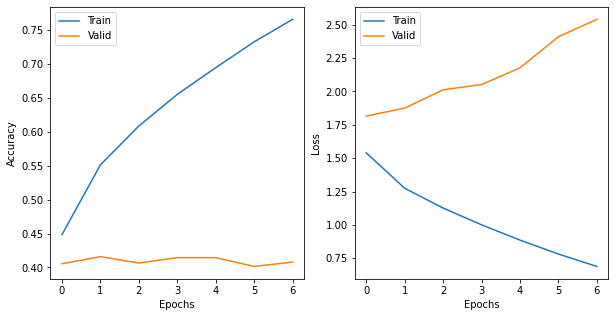

In [14]:
#  ## menampilkan history metrics akurasi dan loss 
import matplotlib.pyplot as plt

train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list = load_metrics(metrics_path)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(epochs_list, train_acc_list, label='Train')
ax1.plot(epochs_list, valid_acc_list, label='Valid')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs_list, train_loss_list, label='Train')
ax2.plot(epochs_list, valid_loss_list, label='Valid')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show() 

In [15]:
set_seed(42)

#Load model
mytokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

myconfig = BertConfig.from_pretrained('indobenchmark/indobert-base-p1',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
myconfig.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
mymodel = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', 
                                                      config=myconfig)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# menggunakan gpu
best_model = mymodel.to(device)

optimizer = optim.AdamW(best_model.parameters(), lr=learning_rate)

load_checkpoint(model_path, best_model, optimizer)

best_model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(best_model, batch_data[:-1], i2w=i2w, device=device_idx)
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()

100%|██████████| 1455/1455 [00:47<00:00, 30.59it/s]


In [17]:
## get y_test for user level
y_test_user_lvl = userlvltest.Lvalue
y_test_user_lvl.values

array([8, 6, 3, 0, 4, 1, 7, 4, 5, 1, 1, 7, 3, 5, 7, 0, 2, 4, 4, 2, 6, 2,
       7, 4, 2, 2, 1, 3, 2, 3, 1, 4, 1, 8, 2, 0, 1, 8, 6, 1, 8, 2, 2, 1,
       7, 4, 2, 3, 6, 0, 3, 4, 4, 3, 1, 5, 4, 0, 0, 2, 0, 4, 0, 3, 3, 3,
       7, 5, 7, 3, 3, 7, 3, 3, 3, 8, 3, 1, 6, 6, 5, 8, 5, 0, 1, 3, 7, 0,
       4, 8, 6, 0, 4, 2, 1, 5, 2, 5, 7, 8, 8, 6, 2, 4, 5, 4, 0, 7, 1, 2,
       0, 1, 8, 3, 8, 2, 0, 8, 4, 0, 4, 8, 2, 7, 3, 7, 2, 5, 6, 3, 3, 3,
       0, 4, 4, 0, 4, 8, 3, 2, 1, 1, 7, 6, 5, 5, 3, 1, 3, 6, 7, 8, 6, 5,
       2, 0, 2, 6, 1, 6, 8, 0, 7, 7, 1, 0, 4, 8, 8, 0, 6, 2, 4, 6, 4, 2,
       4, 8, 3, 1, 3, 6, 1, 6, 3, 8, 8, 1, 6, 0, 5, 8, 8, 3, 1, 2, 8, 2,
       0, 1, 2, 0, 4, 6, 2, 2, 6, 4, 0, 5, 6, 5, 4, 8, 5, 4, 7, 4, 3, 5,
       3, 8, 5, 2, 6, 8, 8, 5, 4, 4, 3, 7, 5, 2, 3, 0, 8, 1, 2, 1, 3, 4,
       1, 7, 4, 2, 5, 4, 3, 3])

In [18]:
## get y_pred for tweets level
y_pred_tweets_lvl = df.iloc[:,1].astype('category')
y_pred_tweets_lvl = y_pred_tweets_lvl.cat.codes

## get y_pred for user level
pred_tweets_lvl = test_df[['screen_name']].copy()
pred_tweets_lvl['Lpredict'] = y_pred_tweets_lvl.values

y_pred_user_lvl = pred_tweets_lvl.groupby(['screen_name'], sort=False).agg(lambda x:x.value_counts().index[0])
y_pred_user_lvl.Lpredict.values

array([3, 3, 3, 1, 3, 3, 7, 0, 3, 3, 1, 7, 3, 3, 7, 0, 2, 3, 3, 3, 6, 2,
       7, 3, 2, 3, 3, 3, 2, 3, 5, 3, 1, 7, 3, 0, 3, 8, 6, 3, 8, 2, 2, 1,
       7, 3, 3, 3, 6, 0, 3, 3, 2, 1, 3, 3, 4, 0, 1, 2, 3, 4, 3, 3, 3, 3,
       3, 5, 3, 3, 3, 7, 3, 3, 2, 3, 3, 3, 6, 8, 5, 8, 3, 3, 3, 3, 3, 0,
       2, 8, 2, 3, 3, 4, 8, 5, 2, 2, 3, 3, 0, 6, 3, 3, 3, 4, 3, 3, 3, 2,
       0, 8, 3, 3, 8, 2, 0, 3, 3, 0, 3, 1, 2, 7, 3, 0, 2, 8, 6, 3, 3, 3,
       0, 3, 4, 3, 3, 3, 3, 2, 1, 2, 3, 8, 5, 3, 3, 3, 3, 3, 3, 3, 6, 1,
       3, 1, 1, 6, 2, 6, 8, 3, 7, 3, 1, 3, 4, 3, 3, 3, 0, 3, 3, 6, 3, 3,
       3, 8, 3, 3, 3, 6, 1, 3, 3, 8, 3, 0, 6, 3, 5, 3, 3, 3, 4, 3, 8, 2,
       3, 1, 3, 3, 4, 6, 2, 2, 3, 3, 0, 3, 6, 3, 3, 8, 1, 4, 7, 3, 3, 3,
       3, 8, 8, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 0, 1, 2, 1, 3, 4,
       3, 7, 3, 2, 3, 3, 3, 3])

In [19]:
from sklearn.metrics import classification_report, accuracy_score

## print classification report for user level prediction
print('accuracy %s' % round(accuracy_score(y_pred_user_lvl, y_test_user_lvl),2 ))
print(classification_report(y_pred_user_lvl, y_test_user_lvl,target_names=label_dict.keys()))

accuracy 0.48
                            precision    recall  f1-score   support

    bali dan nusa tenggara       0.38      0.62      0.48        16
               jabodetabek       0.32      0.53      0.40        17
     jawa barat dan banten       0.59      0.73      0.66        26
jawa tengah dan yogyakarta       0.94      0.26      0.40       132
                jawa timur       0.26      0.82      0.40        11
                kalimantan       0.23      0.83      0.36         6
          maluku dan papua       0.61      1.00      0.76        14
                  sulawesi       0.50      0.91      0.65        11
                  sumatera       0.38      0.65      0.48        17

                  accuracy                           0.48       250
                 macro avg       0.47      0.71      0.51       250
              weighted avg       0.71      0.48      0.47       250



In [21]:
y_pred_user_lvl.to_csv('bert_result/indoNLU2e_5ResultsVote.csv.csv')